Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma empresa de Diagnóstico Médico por Imagem para auxiliar os médicos em suas decisões. O case passado pela contratante se refere a detectar câncer de pele por meio de imagens de lesões. Base de Dados

Será utilizada uma base de dados com imagens de lesões na pele, sejam elas benignas ou malignas. Existe também arquivos .csv descrevendo as variáveis respostas das imagens. O download das imagens usadas estão no links; já os arquivos descritivos, indicando quais imagens são treino, validação, teste e as respectivas variáveis resposta estão disponíveis nesse link.

Do ISIC 2017, devem ser utilizadas as imagens de Nevus e Melanoma. Para complementar a base, rebalanceando as classes, devem ser utilizadas as imagens de Melanoma do ISIC 2018. No notebook disponível nesse link existe uma sugestão de como começar a organizar um dataframe com os nomes dos arquivos. Definições Nota

A nota final da squad será composta por:

Desempenho do modelo em uma base de label escondida (50 pontos)
    A squad com melhor desempenho na base escondida receberá 50 pontos;
    A squad com segundo melhor desempenho na base escondida receberá 45 pontos;
    A squad com terceiro melhor desempenho na base escondida receberá 40 pontos;
    A squad com quarto melhor desempenho na base escondida receberá 35 pontos;
Complexidade da Arquitetura da Rede (25 pontos)
Complexidade do Pré-processamentos (25 pontos)

Regras de Entrega

Um notebook com o desenvolvimento do modelo, incluindo arquitetura da rede e pré-processamentos aplicados, de forma explicativa.
E uma base com o ID da imagem e a variável resposta predita no formato de probabilidade de câncer.
    :warning: Entregar as predições com a probabilidade do tumor ocorrer.
Um vídeo de até 10 min fazendo o walk-through desse notebook (não se preocupem em criar a apresentação ou coisas do tipo, apenas gravem a tela do notebook explicando cada step).

Informações Complementares

O projeto é baseado na Task 3 do desafio global do ISIC 2017, disponível aqui. Foi feita uma simplificação do case ao considerar apenas melanoma e nevus, além de terem sido usadas imagens de melanoma do ISIC 2018 para balancear o conjunto de dados. Nesse link, há um paper escrito pelo Maurício Chigutti descrevendo como o problema foi atacado.

In [1]:
from random import randint
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle



#Códgo para usar a CPU ao inves da GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""
###

from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, Input
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D
from tensorflow.keras.layers import BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from PIL import Image

seed = 123

# Funções

In [101]:

# carregamento 
def get_images_n_labels(dataframe, path = 'treino_full_non_preproc/', 
                        series_name = 'img', label_name = 'pos', i = 300, j = 300):
    
    x = []
    y = []
    
    for n in range(dataframe.shape[0]):
        
        img = cv2.imread(path + dataframe[series_name].iloc[n])
        img = cv2.resize(img, (i, j))
        x.append(img)
        y.append(dataframe[label_name].iloc[n])
        
    return np.array(x), np.array(y)

# pré processamento

def segmentation(img):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations = 3)
    res = cv2.bitwise_and(img,img,mask = sure_bg)
    
    return res

def bgr_CLAHE(img):
    
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize = (6, 6))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return img

def img_preproc(img):
    
    img = bgr_CLAHE(segmentation(img))
    img = img / 255

    
    return img

# augmentation

def zoom(img, original_dim = [300, 300], h_slice = [15, 285], v_slice = [15, 285]):

    img = img[v_slice[0] : v_slice[1], h_slice[0] : h_slice[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img 

# horizontal shift
def h_shift(image, original_dim = [300, 300], shift = 5):
    
    T_x = shift
    T_y = 0
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[0 : original_dim[0], shift : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

# vertical shift
def v_shift(image, original_dim = [300, 300], shift = 5):
    
    T_x = 0
    T_y = shift
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[shift : original_dim[0], 0 : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

def rotation_90(img):

    rows, cols, chnls = img.shape
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), 90, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    
    return img

def data_augmentation(x, y):
    
    augmentation_imgs = []
    augmentation_labels = []

    for n in range(len(x)):

        image = x[n]
        classe = y[n]
        augment = randint(0, 2) # booleano (33.3% de chance de aplicar augmentation)

        if augment == 1:
            process = randint(0, 5) # seleção aleatória do processo de augmentation

            if process == 0:
                image = cv2.flip(image, 0)
                augmentation_imgs.append(image) # horizontal flip
                augmentation_labels.append(classe)

            if process == 1:
                image = zoom(image)
                augmentation_imgs.append(image) # zoom 0.2
                augmentation_labels.append(classe)

            if process == 2:
                image = h_shift(image)
                augmentation_imgs.append(image) # horizontal shift
                augmentation_labels.append(classe)

            if process == 3:
                image = v_shift(image)
                augmentation_imgs.append(image) # vertical shift
                augmentation_labels.append(classe)

            if process == 4:
                image = rotation_90(image)
                augmentation_imgs.append(image) # rotaton 90°
                augmentation_labels.append(classe)
                
    return augmentation_imgs, augmentation_labels

# consolidando os processos acima em um função
def single_batch_prep(batch_df, width = 300, height = 300):
    
    x, y = get_images_n_labels(batch_df)

    # pré processamento de imagens
    x = [img_preproc(i) for i in x]

    # data augmentation
    augmentation_imgs, augmentation_labels = data_augmentation(x, y)
    
    return np.array(x + augmentation_imgs), np.array(list(y) + augmentation_labels)


def get_batch(nn_name, batch_desc, valid_desc, valid_dir, batch_size, epochs, 
              encode = False):
    
    model = load_model(nn_name)
    batch = pickle.load(open(batch_desc, 'rb'))
    x_treino, y_treino = single_batch_prep(batch)
    
    valid = pickle.load(open(valid_desc, 'rb'))
    x_valid, y_valid = get_images_n_labels(valid, path = valid_dir)
    
    if encode == True:
        model.fit(x_treino, x_treino, batch_size = batch_size, epochs = epochs, 
                  validation_data = (x_valid, x_valid))
                  
    model.save(nn_name)

# Diretórios

In [53]:
#Caminhos dos  csvs:
treino_2018 ="/media/leandro/2AC8-9C09/ISIC/isic_2018_treino.csv"
treino_2017 ="/media/leandro/2AC8-9C09/ISIC/isic_2017_treino.csv"

validacao =  "/media/leandro/2AC8-9C09/ISIC/isic_2017_validacao.csv"


In [54]:
# # Caminhos dos  csvs (win):
# treino_2018 =r"D:\ISIC\isic_2018_treino.csv"
# treino_2017 =r"D:\ISIC\isic_2017_treino.csv"
# teste =      r"D:\ISIC\isic_2017_teste.csv"
# validacao =  r"D:\ISIC\isic_2017_validacao.csv"

In [55]:
# diretorio_treino = '/media/leandro/2AC8-9C09/ISIC/treino/'
# diretorio_teste = '/media/leandro/2AC8-9C09/ISIC/isic_2017_teste/'
# diretorio_val = "/media/leandro/2AC8-9C09/ISIC/isic_2017_validacao/"

In [56]:
diretorio_treino = "/media/leandro/2AC8-9C09/ISIC/treino/"
diretorio_teste =  "/media/leandro/2AC8-9C09/ISIC/isic_2017_teste/"
diretorio_val =    "/media/leandro/2AC8-9C09/ISIC/isic_2017_validacao/"


## Tratamento, balanceamento e split de treino e teste de descritivos

In [57]:
# primeiramente, abrimos os descritivos dos dados de treino, a fim de analisar o balanceamento dos dados;
# julgamos válido ajustar a rede a um conjunto de dados balanceado, assim, evitando enviesar a rede

df_treino_2017 = pd.read_csv(treino_2017)
df_treino_2018 = pd.read_csv(treino_2018)

In [58]:
# analisando descritivo de treino de 2017
df_treino_2017.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [59]:
# ------- TREINO 2017

df_treino_2017['image_id'] = df_treino_2017['image_id'].apply(lambda x: x + '.jpg')
df_treino_2017['nevus'] = ((df_treino_2017['melanoma'] == 0) & 
                           (df_treino_2017['seborrheic_keratosis'] == 0)).astype(float)
df_treino_2017.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_treino_2017 = df_treino_2017.loc[(df_treino_2017['melanoma'] == 1) | (df_treino_2017['nevus'] == 1)]

# nesta célula, adicionamos extensões aos nomes dos arquivos, para que estes correspondam exatamente aos nomes
# que de fato seriam usados para acessar as imagens, por código, em seguida, precisávamos saber quais imagens
# eram casos de 'nevus', como esta flag não existe, inferimos que casos que não fossem 'melanoma', nem 
# 'seborrheic_keratosis' seriam 'nevus', à partir disso, criamos uma terceira flag, eliminamos a flag
# 'seborrheic_keratosis', que não nos convinha, por fim, mantivemos no dataframe, apenas as imagens
# que representassem ou casos de 'nevus' ou 'melanoma'

In [60]:
df_treino_2017.head()

,image_id,melanoma,nevus
0,ISIC_0000000.jpg,0.0,1.0
1,ISIC_0000001.jpg,0.0,1.0
2,ISIC_0000002.jpg,1.0,0.0
3,ISIC_0000003.jpg,0.0,1.0
4,ISIC_0000004.jpg,1.0,0.0


In [61]:
# partimos para o descritivo de treino de 2018

df_treino_2018.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# ------- TREINO 2018

df_treino_2018['image'] = df_treino_2018['image'].apply(lambda x: x + '.jpg')
df_treino_2018 = df_treino_2018.loc[(df_treino_2018['MEL'] == 1) | (df_treino_2018['NV'] == 1)]
df_treino_2018 = df_treino_2018[['image', 'MEL', 'NV']]
# nesta célula, apenas adicinamos as extensões aos nomes dos arquivos, filtramos imagens que representassem 
# casos de 'nevus' ou 'melanoma', por meio das flags 'NEV' e 'ML'

In [63]:
df_treino_2018.head()

,image,MEL,NV
0,ISIC_0024306.jpg,0.0,1.0
1,ISIC_0024307.jpg,0.0,1.0
2,ISIC_0024308.jpg,0.0,1.0
3,ISIC_0024309.jpg,0.0,1.0
4,ISIC_0024310.jpg,1.0,0.0


In [64]:
# aqui, unificamos os nomes das series dos descritivos, para que possam ser concatenados
df_treino_2018.columns = ['img', 'pos', 'neg']
df_treino_2017.columns = ['img', 'pos', 'neg']

In [65]:
# como podemos ver abaixo, as bases estão desbalanceadas

In [66]:
df_treino_2017['pos'].value_counts(1)

0.0    0.785796
1.0    0.214204
Name: pos, dtype: float64

In [67]:
df_treino_2018['pos'].value_counts(1)

0.0    0.857636
1.0    0.142364
Name: pos, dtype: float64

In [68]:
# nesta célula, juntamos as duas bases, como o intuito de obter um conjunto balanceado de dados

# separando casos positivos e negativos de cada ano
pos_2018 = df_treino_2018.loc[df_treino_2018['pos'] == 1]
pos_2017 = df_treino_2017.loc[df_treino_2017['pos'] == 1]

neg_2018 = df_treino_2018.loc[df_treino_2018['neg'] == 1]
neg_2017 = df_treino_2017.loc[df_treino_2017['neg'] == 1]

# juntando casos positivos e negativos de todos os anos
full_pos = pd.concat([pos_2017, pos_2018], axis = 0)
full_neg = pd.concat([neg_2017, neg_2018], axis = 0)

# amostrando aleatoriamente, n dados negativos, estes consistirão nas observações negativas (a amostragem
# é feita para separar um número de imagens equivalente ao número de imagens positivas que temos à disposição)
full_neg = full_neg.sample(n = full_pos.shape[0], random_state = seed)

full_pos = full_pos[['img', 'pos', 'neg']]
full_neg = full_neg[['img', 'pos', 'neg']]

filenames = pd.concat([full_pos, full_neg]).reset_index().drop('index', axis = 1)

filenames['pos'].value_counts()

0.0    1487
1.0    1487
Name: pos, dtype: int64

# na célula abaixo, separo 20% das imagens para teste
### na hora de tirar a métrica, carregar 'df_teste' com a função 'get_images_n_labels' e testar na rede

In [69]:
# com base no conjunto balanceado, obtemos splits de treino e teste
df_treino, df_teste = train_test_split(filenames, test_size = 0.2, random_state = seed)

In [70]:
# analisamos aqui, o descritivo de validação

df_valid = pd.read_csv(validacao)

In [71]:
df_valid.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [72]:
df_valid['image_id'] = df_valid['image_id'].apply(lambda x: x + '.jpg')
df_valid['nevus'] = ((df_valid['melanoma'] == 0) & 
                           (df_valid['seborrheic_keratosis'] == 0)).astype(float)
df_valid.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_valid = df_valid.loc[(df_valid['melanoma'] == 1) | (df_valid['nevus'] == 1)]

df_valid.columns = ['img', 'pos', 'neg']
# para o tratamento do descritivo de validação, foi necessário adicionar extensões e criar a flag 'nevus', 
# de forma similar ao tratamento do descritivo de 2017, além disso, filtramos por apenas casos de 
# 'melanoma' ou 'nevus', também foram aplicados os mesmos nomes para as series 

In [73]:
df_valid.head()

,img,pos,neg
0,ISIC_0001769.jpg,0.0,1.0
1,ISIC_0001852.jpg,0.0,1.0
2,ISIC_0001871.jpg,0.0,1.0
3,ISIC_0003462.jpg,0.0,1.0
4,ISIC_0003539.jpg,0.0,1.0


In [74]:
# como podemos observar, a base de validação está desbalanceada

df_valid['pos'].value_counts(1)

0.0    0.722222
1.0    0.277778
Name: pos, dtype: float64

In [75]:
# para balanceá-la, elminaremos casos negativos o suficiente para que o número resultante se equipare 
# ao número de casos positivos

df_valid_pos = df_valid.loc[df_valid['pos'] == 1]
df_valid_neg = df_valid.loc[df_valid['neg'] == 1]

In [76]:
len(df_valid_pos), len(df_valid_neg)

# amostraremos 30 valores aleatórios dentre os casos negativos, e estes serão concatenados ao conjunto de
# casos positivos, o conjunto resultante consistirá no descritivo de validação

(30, 78)

In [77]:
df_valid_neg = df_valid_neg.sample(30, random_state = seed)
df_valid = pd.concat([df_valid_pos, df_valid_neg])

In [78]:
df_valid['pos'].value_counts(1)

0.0    0.5
1.0    0.5
Name: pos, dtype: float64

In [79]:
# descritivo de teste (cujas predições devemos entregar)

df_pred = pd.read_csv(teste)

In [80]:
df_pred.head()

,image_id
0,ISIC_0012086
1,ISIC_0012092
2,ISIC_0012095
3,ISIC_0012134
4,ISIC_0012136


In [81]:
df_pred['image_id'] = df_pred['image_id'].apply(lambda x: x + '.jpg')
df_pred.columns = ['img']

# para o tratamento do descritivo de teste, aplicamos extensões e unificamos nome da series

In [82]:
df_pred.head()

,img
0,ISIC_0012086.jpg
1,ISIC_0012092.jpg
2,ISIC_0012095.jpg
3,ISIC_0012134.jpg
4,ISIC_0012136.jpg


In [83]:
# ao final do processo, possuímos df_treino, df_teste, df_valid, df_pred

In [84]:
df_treino = df_treino.reset_index()
df_valid = df_valid.reset_index()
df_treino.drop('index', axis = 1, inplace = True)
df_valid.drop('index', axis = 1, inplace = True)

## Pré-processamento

In [32]:
# farei o pré processamento das imagens conforme estiver alimentando o ajuste da rede, este será realizado em 
# batches

## se for carregar todos os dados de uma vez, não precisa do próximo bloco

In [72]:
# divisão dos dados de treino em batches

n_batches = 5
data = df_treino
batch_list = []

resto = data.shape[0] % n_batches
step = data.shape[0] // n_batches
count = 0
lower_idx = 0

for n in range(n_batches):
    
    upper_idx = lower_idx + step 
    
    exec(f'batch_{count} = data.iloc[{lower_idx}:{upper_idx}]')
    exec(f'batch_list.append(batch_{count})')
    
    count += 1
    lower_idx += step
    
# somando resto ao último batch
batch_list[-1] = pd.concat([batch_list[-1], df_treino[-4:]])

# agora temos a lista 'batch_list', esta possui cinco dataframes, cada um deles, contendo uma porção de 
# 'df_treino', carregaremos cada batch e ajustaremos a rede a cada um deles

# Criação do Encoder

In [109]:
px_h, px_v, chnls = 300, 300, 3
ipt_e = Input(shape = (px_h, px_v, chnls))

encoder = Conv2D(50, (3, 3), input_shape = (px_h, px_v, chnls), activation = 'relu', padding = 'same')(ipt_e)
encoder = MaxPool2D((5, 5))(encoder)
encoder = Conv2D(50, (5, 5), activation = 'relu', padding = 'same')(encoder)
encoder = MaxPool2D((5, 5))(encoder)
encoder = Conv2D(50, (5, 5), activation = 'relu', padding = 'same')(encoder)
encoder = Flatten()(encoder)

encoder = Dense(60, name = 'gargalo')(encoder)

decoder = Dense(7200)(encoder)
decoder = Reshape(target_shape = (12, 12,50))(decoder)
decoder = Conv2D(50, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((5, 5))(decoder)
decoder = Conv2D(50, (5, 5), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((5, 5))(decoder)
decoder = Conv2D(4, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(decoder)

autoencoder = Model(inputs = ipt_e, outputs = decoder, name = 'autoencoder')
autoencoder.compile(loss = 'mean_squared_error')

In [110]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 300, 300, 50)      1400      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 50)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 50)        62550     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 50)        62550     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              

In [43]:
# Salvamento do encoder

#pickle.dump(batch_0, open('batch_0.pkl', 'wb'))
#pickle.dump(batch_1, open('batch_1.pkl', 'wb'))
# pickle.dump(batch_2, open('batch_2.pkl', 'wb'))
# pickle.dump(batch_3, open('batch_3.pkl', 'wb'))
# pickle.dump(batch_4, open('batch_4.pkl', 'wb'))

#autoencoder.save('ae.h5')

In [ ]:
#get_batch('ae.h5', 'batch_0.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
#get_batch('ae.h5', 'batch_1.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
#get_batch('ae.h5', 'batch_2.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
#get_batch('ae.h5', 'batch_3.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [ ]:
#get_batch('ae.h5', 'batch_4.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

# Este autoencoder foi ajustado?

In [35]:
#Carregando o encoder completo
autoencoder = load_model('ae.h5')

In [41]:
#df_valid = pickle.load(open('df_valid.pkl', 'rb'))

x_valid, y_valid = get_images_n_labels(df_valid, path = diretorio_val)

In [42]:
x_valid[0].shape

(300, 300, 3)

In [43]:
x_treino, y_treino = get_images_n_labels(df_treino, path = diretorio_treino)

In [44]:
x_treino_cod = autoencoder.predict(x_treino)
x_valid_cod = autoencoder.predict(x_valid)

In [45]:
x_treino_cod.shape, x_valid_cod.shape

((2379, 300, 300, 3), (60, 300, 300, 3))

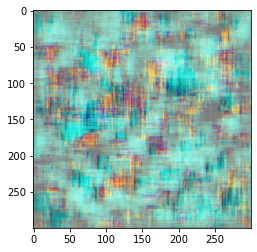

In [46]:
plt.imshow(x_treino_cod[0])

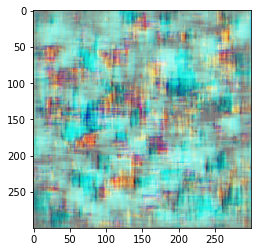

In [47]:
plt.imshow(x_valid_cod[0])

# Rede primaria

## Essa rede será usada com e sem encoder com o intuito de verificar se o mesmo traz algum ganho preditivo

In [57]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(50, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [58]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 298, 298, 50)      1400      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 296, 296, 50)      22550     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 148, 148, 50)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 146, 50)      22550     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 144, 144, 50)      22550     
_________________________________________________________________
average_pooling2d (AveragePo (None, 72, 72, 50)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 70, 70, 50)        2

In [59]:
batch_size = 100

# Testaremos o encoder inteiro nessa primeira rede para ver se ele dá algum ganho preditivo em relação ao modelo sem encoder

In [61]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino_cod, y_treino, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 542s 7s/step - loss: 7.2929 - val_loss: 4.1658
Epoch 2/100
75/75 [==============================] - 525s 7s/step - loss: 4.5573 - val_loss: 3.3255
Epoch 3/100
75/75 [==============================] - 523s 7s/step - loss: 3.6478 - val_loss: 2.9830
Epoch 4/100
75/75 [==============================] - 521s 7s/step - loss: 2.9755 - val_loss: 2.4990
Epoch 5/100
75/75 [==============================] - 504s 7s/step - loss: 2.5327 - val_loss: 2.1962
Epoch 6/100
75/75 [==============================] - 494s 7s/step - loss: 1.9167 - val_loss: 1.7699
Epoch 7/100
75/75 [==============================] - 492s 7s/step - loss: 1.4936 - val_loss: 1.3402
Epoch 8/100
75/75 [==============================] - 492s 7s/step - loss: 1.1983 - val_loss: 1.1949
Epoch 9/100
75/75 [==============================] - 491s 7s/step - loss: 1.0529 - val_loss: 0.9803
Epoch 10/100
75/75 [==============================] - 497s 7s/step - loss: 0.8804 - val_loss: 0.8552

In [62]:
y_treino_pred = cnn.predict(x_treino_cod)

In [64]:
roc_auc_score(y_treino, y_treino_pred)

0.7878179204437352

# salvando o gargalo

In [78]:
#encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('gargalo').output)
#encoder.save('gargalo.h5')

# Rede sem o encoder

In [65]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 494s 7s/step - loss: 0.7654 - val_loss: 4.0895
Epoch 2/100
75/75 [==============================] - 491s 7s/step - loss: 0.7845 - val_loss: 1.2205
Epoch 3/100
75/75 [==============================] - 501s 7s/step - loss: 0.7351 - val_loss: 1.1920
Epoch 4/100
75/75 [==============================] - 492s 7s/step - loss: 0.7375 - val_loss: 5.2102
Epoch 5/100
75/75 [==============================] - 495s 7s/step - loss: 0.8029 - val_loss: 1.2600
Epoch 6/100
75/75 [==============================] - 498s 7s/step - loss: 0.7242 - val_loss: 2.5924
Epoch 7/100
75/75 [==============================] - 500s 7s/step - loss: 0.7948 - val_loss: 1.0614
Epoch 8/100
75/75 [==============================] - 488s 7s/step - loss: 0.7423 - val_loss: 1.0958
Epoch 9/100
75/75 [==============================] - 487s 6s/step - loss: 0.7310 - val_loss: 0.9955
Epoch 10/100
75/75 [==============================] - 487s 6s/step - loss: 0.6975 - val_loss: 1.4554

In [66]:
y_treino_pred = cnn.predict(x_treino)

In [67]:
roc_auc_score(y_treino, y_treino_pred)

0.7544713470511655

# Como o ganho foi pequeno optamos por manter a análise com ele mas também manteremos as predições sem o encoder.

# Sem o encoder

In [67]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(100, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(100, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(100, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [68]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 298, 298, 100)     2800      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 296, 296, 50)      45050     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 148, 50)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 146, 146, 50)      22550     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 144, 144, 50)      22550     
_________________________________________________________________
average_pooling2d_6 (Average (None, 72, 72, 50)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 70, 70, 100)      

In [69]:
batch_size = 100

In [70]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 865s 12s/step - loss: 16.8028 - val_loss: 18.4377
Epoch 2/100
75/75 [==============================] - 817s 11s/step - loss: 11.5329 - val_loss: 16.1671
Epoch 3/100
75/75 [==============================] - 805s 11s/step - loss: 8.7762 - val_loss: 10.7186
Epoch 4/100
75/75 [==============================] - 815s 11s/step - loss: 6.3133 - val_loss: 12.1226
Epoch 5/100
75/75 [==============================] - 793s 11s/step - loss: 4.4743 - val_loss: 6.1139
Epoch 6/100
75/75 [==============================] - 794s 11s/step - loss: 3.1176 - val_loss: 2.3271
Epoch 7/100
75/75 [==============================] - 804s 11s/step - loss: 1.9175 - val_loss: 3.9498
Epoch 8/100
75/75 [==============================] - 807s 11s/step - loss: 1.2816 - val_loss: 1.3688
Epoch 9/100
75/75 [==============================] - 795s 11s/step - loss: 1.0344 - val_loss: 1.2685
Epoch 10/100
75/75 [==============================] - 807s 11s/step - loss: 0.9841 - 

In [71]:
y_treino_pred = cnn.predict(x_treino)

In [72]:
roc_auc_score(y_treino, y_treino_pred)

0.36031501917452713

In [73]:
cnn.save("2_rede_sem_encoder")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 2_rede_sem_encoder/assets


# Terceira rede sem encoder

In [114]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(50, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Flatten())
cnn.add(Dense(10, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(300, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(250, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))


In [115]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 298, 298, 50)      1400      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 296, 296, 50)      22550     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 148, 148, 50)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 146, 146, 50)      22550     
_________________________________________________________________
average_pooling2d (AveragePo (None, 73, 73, 50)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 50)        22550     
_________________________________________________________________
batch_normalization (BatchNo (None, 71, 71, 50)        2

In [116]:
batch_size = 100

In [117]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 463s 6s/step - loss: 30.9998 - val_loss: 28.5118
Epoch 2/100
75/75 [==============================] - 476s 6s/step - loss: 18.1806 - val_loss: 16.5650
Epoch 3/100
75/75 [==============================] - 480s 6s/step - loss: 9.1062 - val_loss: 6.7281
Epoch 4/100
75/75 [==============================] - 473s 6s/step - loss: 3.6415 - val_loss: 1.9996
Epoch 5/100
75/75 [==============================] - 472s 6s/step - loss: 1.4861 - val_loss: 1.1633
Epoch 6/100
75/75 [==============================] - 471s 6s/step - loss: 1.0418 - val_loss: 6.8894
Epoch 7/100
75/75 [==============================] - 472s 6s/step - loss: 0.8415 - val_loss: 2.0609
Epoch 8/100
75/75 [==============================] - 469s 6s/step - loss: 0.8189 - val_loss: 4.6494
Epoch 9/100
75/75 [==============================] - 470s 6s/step - loss: 0.7604 - val_loss: 3.8982
Epoch 10/100
75/75 [==============================] - 472s 6s/step - loss: 0.8183 - val_loss: 0.

In [118]:
y_treino_pred = cnn.predict(x_treino)

In [119]:
roc_auc_score(y_treino, y_treino_pred)

0.3381045842173782

In [120]:
cnn.save("3_rede_sem_encoder")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 3_rede_sem_encoder/assets


# Quarta rede sem encoder

In [121]:
cnn_i, cnn_j, cnn_chnls = 300, 300, 3

cnn = Sequential()
cnn.add(Conv2D(100, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(100, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Flatten())
cnn.add(Dense(10, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(300, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(350, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))


In [122]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 298, 298, 100)     2800      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 296, 296, 100)     90100     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 148, 100)     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 146, 146, 50)      45050     
_________________________________________________________________
average_pooling2d_2 (Average (None, 73, 73, 50)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 71, 71, 50)        22550     
_________________________________________________________________
batch_normalization_4 (Batch (None, 71, 71, 50)       

In [123]:
batch_size = 100

In [124]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino, y_treino, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 957s 13s/step - loss: 28.2791 - val_loss: 18.9822
Epoch 2/100
75/75 [==============================] - 963s 13s/step - loss: 14.7912 - val_loss: 9.7140
Epoch 3/100
75/75 [==============================] - 960s 13s/step - loss: 7.7173 - val_loss: 11.8149
Epoch 4/100
75/75 [==============================] - 963s 13s/step - loss: 4.3063 - val_loss: 7.9530
Epoch 5/100
75/75 [==============================] - 964s 13s/step - loss: 2.3132 - val_loss: 1.5544
Epoch 6/100
75/75 [==============================] - 962s 13s/step - loss: 1.3285 - val_loss: 1.1157
Epoch 7/100
75/75 [==============================] - 960s 13s/step - loss: 0.9197 - val_loss: 1.0315
Epoch 8/100
75/75 [==============================] - 967s 13s/step - loss: 0.8089 - val_loss: 0.9440
Epoch 9/100
75/75 [==============================] - 970s 13s/step - loss: 0.7783 - val_loss: 0.8151
Epoch 10/100
75/75 [==============================] - 972s 13s/step - loss: 0.7776 - va

In [125]:
y_treino_pred = cnn.predict(x_treino)

In [126]:
roc_auc_score(y_treino, y_treino_pred)

0.654300875398792

In [127]:
cnn.save("4_rede_sem_encoder")

INFO:tensorflow:Assets written to: 4_rede_sem_encoder/assets


## Com o encoder

In [90]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('gargalo').output)

In [92]:
x_treino_cod = encoder.predict(x_treino)
x_valid_cod = encoder.predict(x_valid)

In [93]:
x_treino_cod.shape

(2379, 60)

# Segunda rede

In [119]:
dim = 60
rede= Sequential()
rede.add(Dense(15, input_dim = dim, activation = 'relu', kernel_regularizer = l2(0.005)))
rede.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(BatchNormalization())
rede.add(Dropout(0.2))
rede.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(100, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dense(1, activation = 'relu'))
     
rede.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [120]:
rede.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 15)                915       
_________________________________________________________________
dense_36 (Dense)             (None, 25)                400       
_________________________________________________________________
dropout_19 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 150)               3900      
_________________________________________________________________
batch_normalization_7 (Batch (None, 150)               600       
_________________________________________________________________
dropout_20 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 150)              

In [121]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

rede.fit(x_treino_cod, y_treino, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 0s 3ms/step - loss: 16.6709 - val_loss: 12.2389
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 12.5496 - val_loss: 9.1708
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 8.6294 - val_loss: 6.6188
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 5.9624 - val_loss: 4.6879
Epoch 5/100
75/75 [==============================] - 0s 2ms/step - loss: 3.9401 - val_loss: 3.0885
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 2.4376 - val_loss: 1.8418
Epoch 7/100
75/75 [==============================] - 0s 2ms/step - loss: 1.5398 - val_loss: 1.2445
Epoch 8/100
75/75 [==============================] - 0s 2ms/step - loss: 1.1662 - val_loss: 1.0575
Epoch 9/100
75/75 [==============================] - 0s 2ms/step - loss: 1.0166 - val_loss: 0.9782
Epoch 10/100
75/75 [==============================] - 0s 2ms/step - loss: 0.8872 - val_loss: 0.9843
Epoch 

In [122]:
y_treino_pred = rede.predict(x_treino_cod)

In [123]:
roc_auc_score(y_treino, y_treino_pred)

0.8399623153047077

In [124]:
rede.save("2_rede_com_encoder")

INFO:tensorflow:Assets written to: 2_rede_com_encoder/assets


# terceira rede

In [125]:
rede= Sequential()
rede.add(Dense(10,input_dim = dim, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(300, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(BatchNormalization())
rede.add(Dropout(0.2))
rede.add(Dense(250, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(BatchNormalization())
rede.add(Dropout(0.2))
rede.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dense(1, activation = 'relu'))        
rede.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))


In [126]:
rede.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 10)                610       
_________________________________________________________________
dropout_22 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 300)               3300      
_________________________________________________________________
dense_43 (Dense)             (None, 200)               60200     
_________________________________________________________________
batch_normalization_8 (Batch (None, 200)               800       
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 250)              

In [127]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

rede.fit(x_treino_cod, y_treino, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 0s 5ms/step - loss: 34.4577 - val_loss: 30.1317
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 27.3462 - val_loss: 23.0125
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 21.3182 - val_loss: 18.1970
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 16.2349 - val_loss: 12.0603
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 10.7892 - val_loss: 8.1623
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 6.8748 - val_loss: 5.0153
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 3.8188 - val_loss: 2.5466
Epoch 8/100
75/75 [==============================] - 0s 3ms/step - loss: 2.1179 - val_loss: 1.6881
Epoch 9/100
75/75 [==============================] - 0s 3ms/step - loss: 1.4703 - val_loss: 1.2245
Epoch 10/100
75/75 [==============================] - 0s 4ms/step - loss: 1.0766 - val_loss: 1.0109


In [128]:
y_treino_pred = rede.predict(x_treino_cod)

In [129]:
roc_auc_score(y_treino, y_treino_pred)

0.7935731056231615

In [130]:
rede.save("3_rede_com_encoder")

INFO:tensorflow:Assets written to: 3_rede_com_encoder/assets


# Quarta rede

In [131]:
rede= Sequential()
rede.add(Dense(10,input_dim = dim, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(300, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(BatchNormalization())
rede.add(Dropout(0.2))
rede.add(Dense(250, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(BatchNormalization())
rede.add(Dropout(0.2))
rede.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dropout(0.2))
rede.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
rede.add(Dense(1, activation = 'relu'))        
rede.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))


In [132]:
rede.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 10)                610       
_________________________________________________________________
dropout_27 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 300)               3300      
_________________________________________________________________
dense_51 (Dense)             (None, 200)               60200     
_________________________________________________________________
batch_normalization_10 (Batc (None, 200)               800       
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 250)              

In [133]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

rede.fit(x_treino_cod, y_treino, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

Epoch 1/100
75/75 [==============================] - 0s 5ms/step - loss: 33.2735 - val_loss: 25.2940
Epoch 2/100
75/75 [==============================] - 0s 4ms/step - loss: 22.5936 - val_loss: 16.6990
Epoch 3/100
75/75 [==============================] - 0s 4ms/step - loss: 14.1369 - val_loss: 9.9419
Epoch 4/100
75/75 [==============================] - 0s 4ms/step - loss: 8.5815 - val_loss: 9.8281
Epoch 5/100
75/75 [==============================] - 0s 4ms/step - loss: 5.4033 - val_loss: 4.0758
Epoch 6/100
75/75 [==============================] - 0s 4ms/step - loss: 3.6239 - val_loss: 2.5000
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 2.0020 - val_loss: 1.5310
Epoch 8/100
75/75 [==============================] - 0s 3ms/step - loss: 1.2579 - val_loss: 1.1208
Epoch 9/100
75/75 [==============================] - 0s 3ms/step - loss: 0.9712 - val_loss: 0.9378
Epoch 10/100
75/75 [==============================] - 0s 4ms/step - loss: 0.8398 - val_loss: 0.8880
Epoc

In [134]:
y_treino_pred = rede.predict(x_treino_cod)

In [135]:
roc_auc_score(y_treino, y_treino_pred)

0.774010211336789

In [136]:
rede.save("4_rede_com_encoder")

INFO:tensorflow:Assets written to: 4_rede_com_encoder/assets


# Fazendo a predição

In [48]:
rede = load_model('2_rede_com_encoder')

In [128]:
df_teste = pd.read_csv("/media/leandro/2AC8-9C09/ISIC/isic_2017_teste.csv", names=["img"], header = 0)
df_teste['img'] = df_teste['img'].apply(lambda x: x + '.jpg')
df_teste['pos'] = 0

In [129]:
df_teste

,img,pos
0,ISIC_0012086.jpg,0
1,ISIC_0012092.jpg,0
2,ISIC_0012095.jpg,0
3,ISIC_0012134.jpg,0
4,ISIC_0012136.jpg,0
...,...,...
595,ISIC_0016068.jpg,0
596,ISIC_0016069.jpg,0
597,ISIC_0016070.jpg,0
598,ISIC_0016071.jpg,0


In [130]:
y_teste = get_images_n_labels(df_teste,diretorio_teste)

In [139]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('gargalo').output)
y_teste_cod = encoder.predict(y_teste)

In [140]:
y_teste_cod.shape

(600, 60)

In [142]:
y_teste_pred = rede.predict(y_teste_cod)

In [143]:
y_teste_pred

array([[0.7924501 ],
       [0.6818824 ],
       [0.7442077 ],
       [0.7767552 ],
       [0.74824655],
       [0.81803125],
       [0.7018146 ],
       [0.7452823 ],
       [0.79970706],
       [0.788625  ],
       [0.76942694],
       [0.78738725],
       [0.74374837],
       [0.79068595],
       [0.77467096],
       [0.7905357 ],
       [0.7374868 ],
       [0.74489796],
       [0.7268514 ],
       [0.76761067],
       [0.75423265],
       [0.80449975],
       [0.680422  ],
       [0.85388076],
       [0.7806877 ],
       [0.74879456],
       [0.769404  ],
       [0.7681559 ],
       [0.7495266 ],
       [0.7083826 ],
       [0.7234371 ],
       [0.75240237],
       [0.7915024 ],
       [0.7940184 ],
       [0.50224215],
       [0.7515868 ],
       [0.76695406],
       [0.77230245],
       [0.7235271 ],
       [0.75242585],
       [0.7702519 ],
       [0.72684324],
       [0.7548657 ],
       [0.77121603],
       [0.7543155 ],
       [0.7176372 ],
       [0.76318085],
       [0.777

In [144]:
df_teste['pos'] = y_teste_pred

In [146]:
df_teste

,img,pos
0,ISIC_0012086.jpg,0.792450
1,ISIC_0012092.jpg,0.681882
2,ISIC_0012095.jpg,0.744208
3,ISIC_0012134.jpg,0.776755
4,ISIC_0012136.jpg,0.748247
...,...,...
595,ISIC_0016068.jpg,0.741734
596,ISIC_0016069.jpg,0.762143
597,ISIC_0016070.jpg,0.675221
598,ISIC_0016071.jpg,0.757978


In [145]:
df_teste.to_csv("DF_predição.csv")